In [1]:
import torch
import torchinfo
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import confusion_matrix

import dsutils 
import metrics


import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
resnet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)


utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet152.eval().to(device)
resnet101.eval().to(device)
resnet50.eval().to(device)
resnet34.eval().to(device)
resnet18.eval().to(device)
alexnet.eval().to(device)

Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /mnt/home/sharvey/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
# filenames for imagenet sample images

# You must replace this with a path to the directory that contains the images you want to use.  We are just using a set of imagenet sample images from https://github.com/EliSchwartz/imagenet-sample-images

fnames = os.listdir('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/class1/test')
fnames.sort()
fnames.remove('.ipynb_checkpoints')

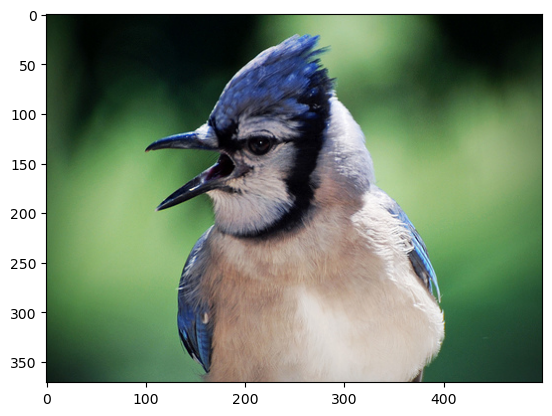

In [4]:
# Show an image

trial_image = fnames[17]
input_image = Image.open('/mnt/ceph/users/sharvey/decoding/imagenet-sample-images/class1/test/'+ trial_image)

plt.imshow(input_image)

In [5]:
# Define preprocessing 

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# preprocess one image
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model


In [7]:
# Test a model (run forward pass with test image)

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(input_batch), dim=1)

results = utils.pick_n_best(predictions=output, n=3)

sample 0: [('jay', '80.5%'), ('bicycle-built-for-two, tandem bicycle, tandem', '0.3%'), ('grey fox, gray fox, Urocyon cinereoargenteus', '0.1%')]


In [8]:
# Split the network in two halfs and extract the representations at a specified layer

# AlexNet

data_dir = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=1029, shuffle=False, num_workers=2)  # not sure why 1029 images in the folder

module1 = list(alexnet.children())[:1]
module2 = list(alexnet.children())[1:2]

anet_1st = nn.Sequential(*[*module1, *module2, dsutils.Flatten()])

anet_2nd = nn.Sequential(*[list(alexnet.children())[-1], dsutils.SoftMaxModule() ])

with torch.no_grad():
    for inputs, _ in trainloader:
        x1 = anet_1st(inputs)
        x2 = anet_2nd(x1) 
        # output = torch.nn.functional.softmax(alexnet(inputs), dim=1) # check classifications



In [9]:
results = utils.pick_n_best(predictions=x2, n=3)

sample 0: [('tench, Tinca tinca', '97.6%'), ('banded gecko', '1.5%'), ('sturgeon', '0.4%')]
sample 1: [('goldfish, Carassius auratus', '100.0%'), ('tench, Tinca tinca', '0.0%'), ('rock beauty, Holocanthus tricolor', '0.0%')]
sample 2: [('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '86.8%'), ('tiger shark, Galeocerdo cuvieri', '3.7%'), ('coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', '2.3%')]
sample 3: [('tiger shark, Galeocerdo cuvieri', '99.5%'), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '0.3%'), ('hammerhead, hammerhead shark', '0.2%')]
sample 4: [('swimming trunks, bathing trunks', '91.7%'), ('sarong', '4.4%'), ('bikini, two-piece', '0.8%')]
sample 5: [('electric ray, crampfish, numbfish, torpedo', '98.3%'), ('stingray', '1.6%'), ('muzzle', '0.0%')]
sample 6: [('stingray', '60.8%'), ('electric ray, crampfish, numbfish, torpedo', '36.8%'), ('sea slug, nudibranch', '0.9%

In [10]:
# Split the network in two halfs and extract the representations at a specified layer

# ResNet 50

data_dir = '/mnt/ceph/users/sharvey/decoding/imagenet-sample-images'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
trainloader = DataLoader(dataset, batch_size=1029, shuffle=False, num_workers=2)  # not sure why 1029 images in the folder

module1 = list(resnet50.children())[:6]
module2 = list(resnet50.children())[6:]

rnet50_1st = nn.Sequential(*[*module1, dsutils.Flatten()])
rnet50_2nd = nn.Sequential(*[*module2, dsutils.SoftMaxModule() ])

with torch.no_grad():
    for inputs, _ in trainloader:
        y1 = rnet50_1st(inputs)
        y2 = rnet50_2nd(y1) 
        output = torch.nn.functional.softmax(resnet50(inputs), dim=1) # check classifications


In [11]:
results = utils.pick_n_best(predictions=y2, n=3)

sample 0: [('tench, Tinca tinca', '78.6%'), ('goldfish, Carassius auratus', '1.1%'), ('coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch', '0.7%')]
sample 1: [('goldfish, Carassius auratus', '82.1%'), ('tench, Tinca tinca', '0.6%'), ('rock beauty, Holocanthus tricolor', '0.2%')]
sample 2: [('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '79.1%'), ('tiger shark, Galeocerdo cuvieri', '11.6%'), ('hammerhead, hammerhead shark', '0.2%')]
sample 3: [('tiger shark, Galeocerdo cuvieri', '78.3%'), ('great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', '0.6%'), ('hammerhead, hammerhead shark', '0.1%')]
sample 4: [('hammerhead, hammerhead shark', '70.8%'), ('swimming trunks, bathing trunks', '10.4%'), ('eel', '2.1%')]
sample 5: [('electric ray, crampfish, numbfish, torpedo', '50.6%'), ('stingray', '12.0%'), ('window screen', '0.3%')]
sample 6: [('stingray', '52.1%'), ('electric ray, crampfish, numbfish

In [15]:
# Compute linear CKA for comparison

cka = metrics.LinearCKA(center_columns=True)
CKAscore = cka.score(x1.numpy(),y1.numpy())
print('The CKA score is ' + str(CKAscore))

The CKA score is 0.40633592


In [15]:
# Compute the normalized ADS score for a particular task covariance matrix, Cz = Identity

ds = metrics.LinearDecodingSimilarity(center_columns=True, a = 0, b = 1)

M = np.shape(x1.numpy())[0]
Cz = np.identity(M)

DSscore = ds.score(x1.numpy(),y1.numpy(),Cz)
print('The DS score is ' + str(DSscore))

The DS score is 0.4063358550054373


In [ ]:
### Study ADS with empirical covariance matrices for random task ensembles 

In [ ]:
# Compute the normalized ADS score for a particular task covariance matrix, Cz, generated from random binary partitions

ds = metrics.LinearDecodingSimilarity(center_columns=True, a=0, b=1)

Cz = dsutils.random_partitions_cov_matrix(M,10)

DSscore = ds.score(x1.numpy(),y1.numpy(),Cz)
print('The DS score is ' + str(DSscore))

In [ ]:
# Compute the normalized ADS score for a particular task covariance matrix, Cz, generated from random Gaussian tasks

ds = metrics.LinearDecodingSimilarity(center_columns=True, a=0, b=1)

Cz = dsutils.gaussian_partitions_cov_matrix(M,10)

DSscore = ds.score(x1.numpy(),y1.numpy(),Cz)
print('The DS score is ' + str(DSscore))

In [ ]:
### Study convergence of random task ensembles to CKA case of Cz = Identity

In [ ]:
ds = metrics.LinearDecodingSimilarity(center_columns=True, a=0, b=1)

X = x1.numpy()
Y = y1.numpy()

M = np.shape(x1.numpy())[0]

ds_scores_binary_all = []

for trial in range(0,10):
    n = 1
    Ns = [n]
    Cz = dsutils.PartitionsCovMatrix(M, n, method='binary')
    Cz.initialize_cov_matrix()
    
    ds_scores_binary = [ds.score(x1.numpy(),y1.numpy(),Cz.matrix)]
    
    # delta_ns = np.arange(5, 100, 5)
    delta_n = 10
    for i in range(1,30):
        Cz.update_cov_matrix(delta_n)
        ds_scores_binary.append(ds.score(X,Y,Cz.matrix))
        n = Cz.n
        Ns.append(n)
        # print(i)

    ds_scores_binary_all.append(ds_scores_binary)
    print(trial)

    
    
    

0
1
2
3
4
5
6
7
8


(0.0, 1.0)

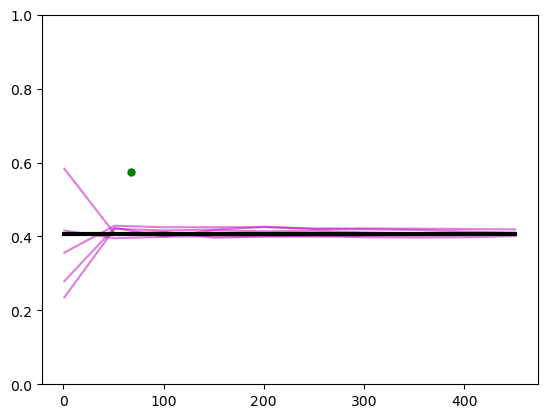

In [29]:
for s in np.arange(len(ds_scores_binary_all)):
    plt.plot(Ns,ds_scores_binary_all[s],label='decoding similarity',color='m',alpha=0.5)

plt.plot(Ns,CKAscore*np.ones(len(Ns)), label='CKA',color='black',linewidth=3)
plt.plot(67,0.575207211364057,'.g',markersize=10)  # from coarse decoding task (later)
plt.ylim(0,1)


In [ ]:
ds = metrics.LinearDecodingSimilarity(center_columns=True, a=0, b=1)

X = x1.numpy()
Y = y1.numpy()

M = np.shape(x1.numpy())[0]

ds_scores_gauss_all = []

for trial in range(0,10):
    n = 1
    Ns = [n]
    Cz = dsutils.PartitionsCovMatrix(M, n, method='gaussian')
    Cz.initialize_cov_matrix()
    
    ds_scores_gauss = [ds.score(x1.numpy(),y1.numpy(),Cz.matrix)]
    
    # delta_ns = np.arange(5, 100, 5)
    delta_n = 20
    for i in range(1,20):
        Cz.update_cov_matrix(delta_n)
        ds_scores_gauss.append(ds.score(X,Y,Cz.matrix))
        n = Cz.n
        Ns.append(n)
        # print(i)

    ds_scores_gauss_all.append(ds_scores_gauss)
    print(trial)

    
    

In [ ]:
for s in np.arange(len(ds_scores_gauss_all)):
    plt.plot(Ns,ds_scores_gauss_all[s],label='decoding similarity',color='m',alpha=0.5)

plt.plot(Ns,CKAscore*np.ones(len(Ns)), label='CKA',color='black',linewidth=3)
plt.ylim(0,1)
# plt.savefig('rn50_anet_ds_cka_a0b1.pdf')


In [ ]:
## Look at coarse category decoding task

In [14]:
import pandas as pd
import random

df = pd.read_csv('imagenet_categories_synset.csv')
print(df)

     index     synset                                              words  \
0        0  n01440764                                 tench, Tinca tinca   
1        1  n01443537                        goldfish, Carassius auratus   
2        2  n01484850  great white shark, white shark, man-eater, man...   
3        3  n01491361                    tiger shark, Galeocerdo cuvieri   
4        4  n01494475                       hammerhead, hammerhead shark   
..     ...        ...                                                ...   
995    995  n13044778                                          earthstar   
996    996  n13052670  hen-of-the-woods, hen of the woods, Polyporus ...   
997    997  n13054560                                             bolete   
998    998  n13133613                              ear, spike, capitulum   
999    999  n15075141       toilet tissue, toilet paper, bathroom tissue   

    categories  
0         fish  
1         fish  
2        shark  
3        shark  
4 

In [15]:
cats = pd.unique(df["categories"])
cats[:]

array(['fish', 'shark', 'bird', 'salamander', 'frog', 'turtle', 'lizard',
       'crocodile', 'dinosaur', 'snake', 'trilobite', 'arachnid', 'bug',
       'ungulate', 'monotreme', 'marsupial', 'coral', 'mollusk',
       'crustacean', 'marine mammals', 'dog', 'wild dog', 'cat',
       'wild cat', 'bear', 'sloth', 'mongoose', 'butterfly',
       'echinoderms', 'rabbit', 'rodent', 'plant', 'hog', 'ferret',
       'armadillo', 'primate', 'technology', 'clothing', 'instrument',
       'boat', 'aircraft', 'furniture', 'vehicle', 'decor',
       'outdoor scene', 'weapon', 'accessory', 'building',
       'sports equipment', 'toy', 'tool', 'other', 'container', 'ball',
       'hat', 'lab equipment', 'food', 'paper', 'train', 'cooking',
       'electronics', 'fence', 'fruit', 'person', 'vegetable', 'flower',
       'fungus'], dtype=object)

In [16]:
# Make coarse category decoding tasks

z = []
M = 1000
for k in cats[:]:
    zpd = (df["categories"] == k)
    zpd = zpd[0:M]
    zarr = 2*zpd.to_numpy() - 1
    # zarr = 1*zpd.to_numpy()
    z.append(zarr.reshape(M,1))

In [22]:
ds = metrics.LinearDecodingSimilarity(center_columns=True, a = 0, b = 1)

M = 1000  # only use first 1000 sample images that we have coarse categories for
Cz = dsutils.bespoke_cov_matrix(z)

DSscore = ds.score(x1.numpy()[0:1000],y1.numpy()[0:1000],Cz)
print('The DS score is ' + str(DSscore))

The DS score is 0.5752072113640575
